<a href="https://colab.research.google.com/github/Eduard25/Redes/blob/master/Tarea6_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Reshape
from tensorflow.keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np
import math

In [16]:
class PDESolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
        #batch_size=tf.shape(data)[0]
        batch_size=100

        x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)
        t = tf.random.uniform((batch_size,1), minval=-5, maxval=5)


        with tf.GradientTape() as tape:
            #Loss value
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(t)

                with tf.GradientTape() as gg:
                    gg.watch(x)
                    input = tf.concat((x,t),axis=1)
                    y_pred = self(input, training=True)

                y_x=gg.gradient(y_pred,x)
                #y_boundary = gg.gradient(y_pred,x0)
            y_xx=g.gradient(y_x,x)
            y_t=g.gradient(y_pred,t)


            pde = y_xx + y_pred

            t_init = tf.zeros(x.shape)
            input_ini = tf.concat((x,t_init),axis=1)
            y_init = self(input_ini, training=True)
            loss = self.mse(0., pde) + self.mse(tf.math.sin(x),y_init)

        # Compute grad
        grads = tape.gradient(loss, self.trainable_variables)

        # Update weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [19]:
model = PDESolver()
model.add(Dense(100, activation='tanh', input_shape=(2,), name="primera"))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='linear'))
#model.add(Reshape(()))
model.summary()

Model: "pde_solver_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera (Dense)             (None, 100)               300       
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1321 (5.16 KB)
Trainable params: 1321 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(optimizer="adam")

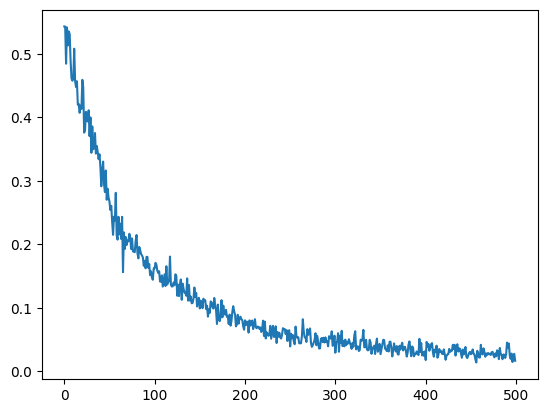

In [21]:
x = tf.random.uniform((10,1), minval=-5, maxval=5)
t = tf.random.uniform((10,1),minval=-5,maxval=5)
input = tf.concat((x,t),axis=1)
history = model.fit(input,epochs=500,verbose=0)
plt.plot(history.history["loss"])

In [22]:
nx=10*2
nt=15*2
x = np.linspace(-5,5, nx)
t = np.linspace(-5, 5, nt)
x, t = np.meshgrid(x, t)

X = np.expand_dims(x.flatten(),axis=-1)
T = np.expand_dims(t.flatten(),axis=-1)
input = np.concatenate((X,T),axis=1)

In [23]:
z = model.predict(input)

19/19 [==============================] - 0s 2ms/step


In [24]:
z=np.reshape(z,x.shape)

Text(0.5, 0, '$p(x,t)$')

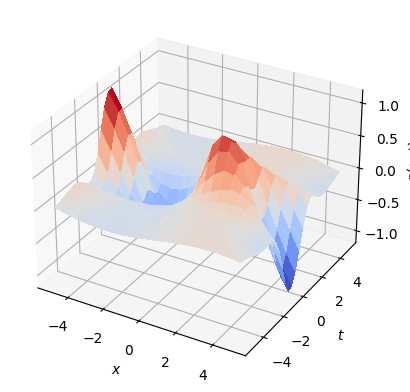

In [25]:
# Plot the surface.
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(x, t, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_ylabel('$t$')
ax.set_xlabel('$x$')
ax.set_zlabel('$p(x,t)$')

https://i.gifer.com/v5T.gif